In [16]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [17]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    
    assert h == w, "Patchify only works for square images"
    
    patches = torch.zeros(n, n_patches ** 2, h * w // n_patches ** 2)
    patch_size = h // n_patches
    
    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size : (i + 1) * patch_size, j * patch_size : (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [18]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [20]:
class MyMSA(nn.Module):
    """
    Multi-Head Self-Attention
    """
    def __init__(self, d, n_heads=2):
        # super constructor
        super(MyMSA, self).__init__()
        
        # Attributes
        self.d = d
        self.n_heads = n_heads
        
        assert d % n_heads == 0, f"Can't split {d} into {n_heads} heads"
        
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [21]:
class MyViTBlock(nn.Module):
    "residual connection"
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, hidden_d * mlp_ratio),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [22]:
if __name__ == "__main__":
    model = MyViTBlock(hidden_d=8, n_heads=2)
    x = torch.randn(7, 50, 8)
    print(model(x).shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x4 and 8x4)

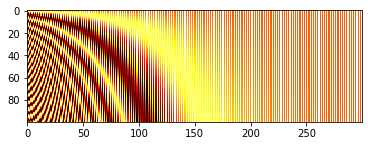

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
    plt.show()

In [ ]:
if __name__ == "__main__":
    model = MyViT(
        chw=(1, 28, 28),
        n_patches=7
    )
    
    x = torch.randn(7, 1, 28, 28)
    print(model(x).shape)

torch.Size([7, 49, 8])


In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8, n_blocks=2, n_heads=2, n_classes=10):
        # super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C, H, W ) = ( 1, 28, 28 )
        self.n_patches = n_patches
        self.hidden_d = hidden_d
        
        assert chw[1] % n_patches == 0, "Patch size must be a divisor of image size"
        assert chw[2] % n_patches == 0, "Patch size must be a divisor of image size" 
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        
        # 1) linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.randn(1, 1, self.hidden_d))
        
        # 3) Positional encoding
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches + 1, self.hidden_d)))
        self.pos_embed.requires_grad = False
        
        # 4) Transformer
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d) for _ in range(n_blocks)])
        
        # 5) MLP Classifier
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, n_classes),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, images):
        # Dividing the image into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches)
        
        # Linear layer
        tokens = self.linear_mapper(patches)
        
        # Adding the class token
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        
        # Adding positional embeddings
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed
        
        # Transformer
        for block in self.blocks:
            out = block(out)
            
        # get the class token
        out = out[:, 0]
        
        return out

In [ ]:
def main():
    # Loading data
    transform = ToTensor()
    
    train_set = MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False)
    
    # Define model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model = MyViT().to(device)
    N_EPOCHS = 10
    LR = 1e-3
    
    # training
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in tqdm(range(N_EPOCHS), desc="Training"):
        train_loss = 0.0
        for batch in tqdm(range(N_EPOCHS), desc="Training"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            train_loss += loss.detach().cpu().item() / len(train_loader)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")
        
        
    # testing
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(y)
        
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {correct / total * 100:.4f}%")